<IPython.core.display.Javascript object>


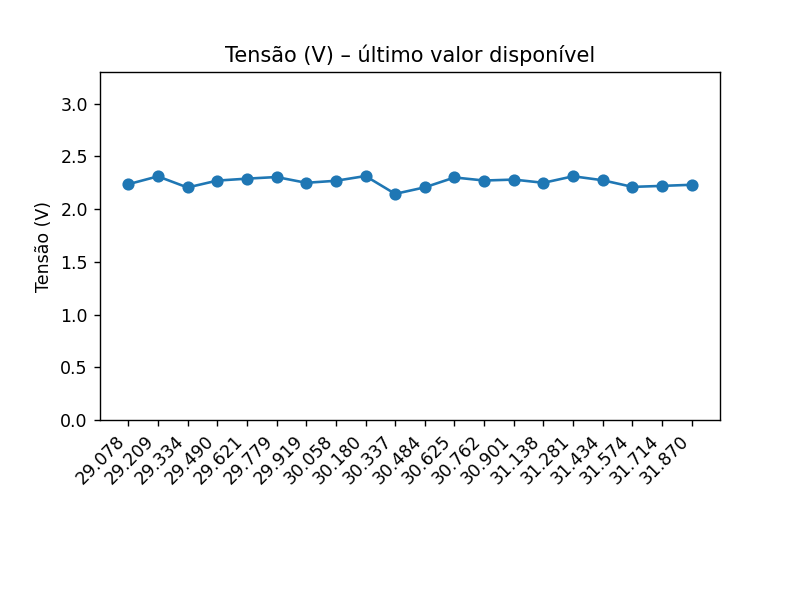

In [34]:
%matplotlib notebook
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import serial

# === CONFIGURAÇÃO DA SERIAL ===
PORT = "COM3"
BAUD = 115200
ser = serial.Serial(PORT, BAUD, timeout=0)  # timeout 0 = não bloqueante
ser.reset_input_buffer()

# === CONFIGURAÇÃO DO GRÁFICO ===
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xs, ys = [], []

# === FUNÇÃO CHAMADA PERIODICAMENTE ===
def animate(i, xs, ys):
    # --- LIFO: drena todo o buffer e fica só com a última linha ---
    last_line = None
    n = ser.in_waiting
    if n:  # há bytes no buffer?
        # lê todos os bytes disponíveis de uma vez
        raw = ser.read(n).decode(errors='ignore')
        # pega apenas a última linha completa
        lines = raw.strip().splitlines()
        if lines:
            last_line = lines[-1]
    else:
        # fallback: tenta ler uma linha (caso chegue algo entre o check e o read)
        last_line = ser.readline().decode(errors='ignore').strip()

    if not last_line:
        return

    # tenta interpretar como volts direto; senão converte de RAW
    try:
        volts = float(last_line)
    except ValueError:
        parts = last_line.split(',')
        try:
            rawv = float(parts[-1])
            volts = (rawv / 4095.0) * 3.3
        except:
            return

    # adiciona ponto (limita a 20)
    xs.append(dt.datetime.now().strftime('%S.%f')[:-3])  # ex.: 14:32:07.123

    ys.append(volts)
    xs[:] = xs[-20:]
    ys[:] = ys[-20:]

    # redesenha
    ax.clear()
    ax.plot(xs, ys, marker='o')
    ax.set_ylim(0, 3.3)
    ax.set_title('Tensão (V) – último valor disponível')
    ax.set_ylabel('Tensão (V)')
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.30)

ani = animation.FuncAnimation(fig, animate, fargs=(xs, ys), interval=100)
plt.show()


In [35]:
ser.close()